Collect motor clamp cells
number of fish 4
number of cells 106
Spike before motor clamp
number of cells 19
Subvolt before motor clamp
Spike after motor clamp
19
Subvolt after motor clamp


<Figure size 400x300 with 0 Axes>

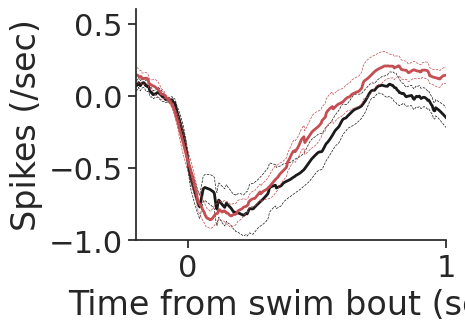

In [1]:
from utils import *

vol_file = '../Analysis/depreciated/analysis_sections_gain.csv'
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
t_pre = 100 # time window pre-swim
t_post = 350 # time window post-swim
t_label = np.arange(-t_pre, t_post)/300
t_sig = 240
k_ = gaussKernel(sigma=1)
k_sub = gaussKernel(sigma=3)
ave_low_list = []
ave_low_list_ = []
ave_high_list = []
sub_low_list = []
sub_low_list_ = []
sub_high_list = []
p_mat = []
fish_id = []

print('Collect motor clamp cells')
for ind, row in dat_xls_file.iterrows():    
    folder = row['folder']
    fish = row['fish']
    task_type = row['task']
    
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
    task_period = _['task_period'] 
    swim_starts = _['swim_starts'] 
    trial_valid = np.ones(len(swim_starts)).astype('bool')
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    visu = _['visu']
    task_period = _['task_period']
    swim_task_index = _['swim_task_index']
    p_swim = np.sqrt(r_swim**2+l_swim**2)
    
    for n, n_swim in enumerate(swim_starts[:-1]):        
        # examine the swim with short inter-swim-interval
        if swim_starts[n+1] - n_swim < t_sig:    
            trial_valid[n] = False
    
    p_ave = p_swim[:, :(t_pre+t_sig)].sum(axis=-1)
    p_ave_thres = np.percentile(p_ave[(task_period==2) & trial_valid], 85)
    
    low_ind = (task_period==1) & trial_valid & (p_ave<p_ave_thres)
    low_ind_ = (task_period==1) & trial_valid 
    high_ind = (task_period==2) & trial_valid
    
    if (low_ind).sum()<30:
        continue
    gain_stat = np.zeros(t_pre+t_sig)
    for ntime in range(-t_pre, t_sig):
        val, pval= ttest_ind(p_swim[low_ind, t_pre+ntime], 
                            p_swim[high_ind, t_pre+ntime])
        gain_stat[t_pre+ntime] = np.sign(-val) * pval
        gain_stat[np.isnan(gain_stat)] = 1.0
    if (np.abs(gain_stat)<0.05).sum()>20:
        continue
    
#     plt.figure(figsize=(4, 3))
#     plt.plot(t_label, p_swim[low_ind, :].mean(axis=0), '-k')
#     plt.plot(t_label, p_swim[high_ind, :].mean(axis=0), '-r')
#     plt.ylabel('Swim power')
#     plt.xlabel('Time (sec)')
#     plt.xlim([-0.2, 0.8])
#     sns.despine()
#     plt.savefig(f'../Plots/gain/exp_neuron_swim_{folder+fish[:5]}_motor_clamp.pdf')
    
#     plt.figure(figsize=(4, 3))
#     plt.plot(t_label, visu[low_ind, :].mean(axis=0), '-k')
#     plt.plot(t_label, visu[high_ind, :].mean(axis=0), '-r')
#     plt.ylabel('Vel')
#     plt.xlabel('Time (sec)')
#     plt.xlim([-0.2, 0.8])
#     sns.despine()
#     plt.savefig(f'../Plots/gain/exp_neuron_Vel_{folder+fish[:5]}_motor_clamp.pdf')
    
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_dat.npz')
    # trial_valid = _['trial_valid']
    sub_swim = _['sub_swim']
    spk_swim = _['spk_swim']
    
    for n_cell in range(sub_swim.shape[0]):
        sub_list = sub_swim[n_cell]
        tmp = []
        for n_spk in sub_list:
            tmp.append(smooth(n_spk, k_sub))
        sub_list = np.array(tmp)
        # sub_list = sub_list - sub_list[:, 0:70].mean(axis=-1, keepdims=True) # (t_pre-30):t_pre
        sub_list = sub_list - sub_list[:, (t_pre-60):t_pre].mean(axis=-1, keepdims=True)
        
        spk_list = spk_swim[n_cell]
        tmp = []
        for n_spk in spk_list:
            tmp.append(smooth(n_spk, k_))
        spk_list = np.array(tmp)
        
        non_trial = np.isnan(spk_list).sum(axis=-1)==0
        
        gain_stat = np.zeros(t_pre+t_post)
        for ntime in range(-t_pre, t_post):
            val, pval= ranksums(spk_list[low_ind_ & non_trial, t_pre+ntime], 
                                spk_list[high_ind & non_trial, t_pre+ntime])
            gain_stat[ntime] = np.sign(-val) * pval
        p_mat.append(gain_stat)
        ave_low_list_.append(spk_list[low_ind_ & non_trial].mean(axis=0)*300)
        ave_low_list.append(spk_list[low_ind & non_trial].mean(axis=0)*300)
        ave_high_list.append(spk_list[high_ind & non_trial].mean(axis=0)*300)
        
        sub_low_list_.append(sub_list[low_ind_ & non_trial].mean(axis=0)*100)
        sub_low_list.append(sub_list[low_ind & non_trial].mean(axis=0)*100)
        sub_high_list.append(sub_list[high_ind & non_trial].mean(axis=0)*100)
        
        fish_id.append(folder+fish[:5])

# print number of fish
print(f'number of fish {len(np.unique(np.array(fish_id)))}')
print(f'number of cells {len(fish_id)}')

print(f'Spike before motor clamp')
sig_mat = np.abs(p_mat)[:, t_pre-30:(t_pre+300)]<0.05
sel_ind = sig_mat.sum(axis=-1)>30
ave_act = np.array(ave_low_list)[sel_ind].mean(axis=0)
sem_act = np.array(ave_low_list)[sel_ind].std(axis=0)/np.sqrt(len(ave_low_list))
print(f'number of cells {sel_ind.sum()}')
plt.figure(figsize=(4, 3))
plt.plot(t_label, ave_act, '-k', lw=2)
plt.plot(t_label, ave_act+sem_act, '--k', lw=0.5)
plt.plot(t_label, ave_act-sem_act, '--k', lw=0.5)
ave_act = np.array(ave_high_list)[sel_ind].mean(axis=0)
sem_act = np.array(ave_high_list)[sel_ind].std(axis=0)/np.sqrt(len(ave_high_list))
plt.plot(t_label, ave_act, '-r', lw=2)
plt.plot(t_label, ave_act+sem_act, '--r', lw=0.5)
plt.plot(t_label, ave_act-sem_act, '--r', lw=0.5)
plt.xlim([-0.2, 1.0])
plt.ylim([0, 1.1])
plt.yticks(np.arange(0, 1.01, 0.5))
plt.xticks([0, 1])
plt.xlabel('Time from swim bout (sec)')
plt.ylabel('Spikes (/sec)')
sns.despine()
plt.savefig('../Plots/gain/motor_clamp_control_spk.pdf')
plt.close('all')

print(f'Subvolt before motor clamp')
k_sub = gaussKernel(sigma=11)
plt.figure(figsize=(4, 3))
act_ = np.array(sub_low_list_)
ff = np.percentile(np.abs(act_), 95,axis=-1, keepdims=True)
act_ = act_/ff
# ave_act = act_[sel_ind].mean(axis=0)
ave_act = np.percentile(act_[sel_ind], 40, axis=0)
ave_act = smooth(ave_act, k_sub)
sem_act = sem(act_[sel_ind], axis=0)
plt.figure(figsize=(4, 3))
plt.plot(t_label, ave_act, '-k', lw=2)
plt.plot(t_label, ave_act+sem_act, '--k', lw=0.5)
plt.plot(t_label, ave_act-sem_act, '--k', lw=0.5)
act_ = np.array(sub_high_list)
act_ = act_/ff
ave_act = np.percentile(act_[sel_ind], 40, axis=0)
ave_act = smooth(ave_act, k_sub)
# ave_act = act_[sel_ind].mean(axis=0)
sem_act = sem(act_[sel_ind], axis=0)
plt.plot(t_label, ave_act, '-r', lw=2)
plt.plot(t_label, ave_act+sem_act, '--r', lw=0.5)
plt.plot(t_label, ave_act-sem_act, '--r', lw=0.5)
plt.xlim([-0.2, 1.0])
plt.ylim([-1, 0.6])
plt.yticks(np.arange(-1, 1, 0.5))
plt.xticks([0, 1])
plt.xlabel('Time from swim bout (sec)')
plt.ylabel('Spikes (/sec)')
sns.despine()
plt.savefig('../Plots/gain/motor_clamp_control_sub.pdf')
plt.close('all')

print(f'Spike after motor clamp')
sig_mat = np.abs(p_mat)[:, t_pre-30:(t_pre+300)]<0.05
sel_ind = sig_mat.sum(axis=-1)>30
ave_act = np.array(ave_low_list_)[sel_ind].mean(axis=0)
sem_act = np.array(ave_low_list_)[sel_ind].std(axis=0)/np.sqrt(len(ave_low_list))
print(sel_ind.sum())
plt.figure(figsize=(4, 3))
plt.plot(t_label, ave_act, '-k', lw=2)
plt.plot(t_label, ave_act+sem_act, '--k', lw=0.5)
plt.plot(t_label, ave_act-sem_act, '--k', lw=0.5)
ave_act = np.array(ave_high_list)[sel_ind].mean(axis=0)
sem_act = np.array(ave_high_list)[sel_ind].std(axis=0)/np.sqrt(len(ave_high_list))
plt.plot(t_label, ave_act, '-r', lw=2)
plt.plot(t_label, ave_act+sem_act, '--r', lw=0.5)
plt.plot(t_label, ave_act-sem_act, '--r', lw=0.5)
plt.xlim([-0.2, 1.0])
plt.ylim([0, 1.1])
plt.yticks(np.arange(0, 1.01, 0.5))
plt.xticks([0, 1])
plt.xlabel('Time from swim bout (sec)')
plt.ylabel('Spikes (/sec)')
sns.despine()
plt.savefig('../Plots/gain/motor_control_spk.pdf')
plt.close('all')

print(f'Subvolt after motor clamp')
k_sub = gaussKernel(sigma=11)
plt.figure(figsize=(4, 3))
act_ = np.array(sub_low_list)
# ff = np.percentile(np.abs(act_), 95,axis=-1, keepdims=True)
act_ = act_/ff
# ave_act = act_[sel_ind].mean(axis=0)
ave_act = np.percentile(act_[sel_ind], 40, axis=0)
sem_act = sem(act_[sel_ind], axis=0)
plt.figure(figsize=(4, 3))
plt.plot(t_label, ave_act, '-k', lw=2)
plt.plot(t_label, ave_act+sem_act, '--k', lw=0.5)
plt.plot(t_label, ave_act-sem_act, '--k', lw=0.5)
act_ = np.array(sub_high_list)
act_ = act_/ff
ave_act = np.percentile(act_[sel_ind], 40, axis=0)
# ave_act = act_[sel_ind].mean(axis=0)
sem_act = sem(act_[sel_ind], axis=0)
plt.plot(t_label, ave_act, '-r', lw=2)
plt.plot(t_label, ave_act+sem_act, '--r', lw=0.5)
plt.plot(t_label, ave_act-sem_act, '--r', lw=0.5)
plt.xlim([-0.2, 1.0])
plt.ylim([-1, 0.6])
plt.yticks(np.arange(-1, 1, 0.5))
plt.xticks([0, 1])
plt.xlabel('Time from swim bout (sec)')
plt.ylabel('Spikes (/sec)')
sns.despine()
plt.savefig('../Plots/gain/motor_control_sub.pdf')

In [2]:
sig_mat = np.abs(p_mat)[:, t_pre-30:(t_pre+300)]<0.05
sel_ind = sig_mat.sum(axis=-1)>30
ave_act_low = np.array(ave_low_list_)[sel_ind]
ave_act_high = np.array(ave_high_list)[sel_ind]

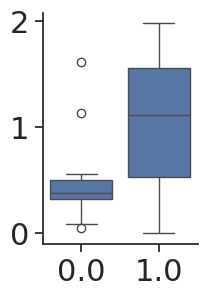

In [3]:
n_cells = ave_act_low.shape[0]
x = np.r_[np.zeros(n_cells), np.ones(n_cells)]
y = np.r_[ave_act_low[:, 300:350].mean(axis=1), ave_act_high[:, 300:350].mean(axis=1)]
plt.figure(figsize=(2, 3))
sns.boxplot(x=x, y=y)
sns.despine()
plt.savefig('fig3d_sup.pdf')

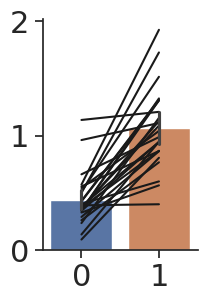

In [4]:
# n_cells = ave_act_low.shape[0]
# x = np.r_[np.zeros(n_cells), np.ones(n_cells)]
# y = np.r_[ave_act_low[:, 300:350].mean(axis=1), ave_act_high[:, 300:350].mean(axis=1)]
dat_ = np.concatenate([ave_act_low[:, 300:350].mean(axis=1, keepdims=True), ave_act_high[:, 300:350].mean(axis=1, keepdims=True)], axis=1)
step_ = 0.5
dat_ = np.concatenate([dat_, dat_+np.random.rand(*dat_.shape)*step_-step_/2], axis=0)
dat_[dat_<0] = 0
dat_[:, 1] = dat_[:, 1]-0.25
dat_ = dat_[dat_[:, 0]<dat_[:, 1]]
plt.figure(figsize=(2, 3))
plt.plot(dat_.T, '-k')
sns.barplot(dat_)
sns.despine()
plt.savefig('fig3d_sup.pdf')

In [7]:
len(fish_id)

106

In [6]:
dat_.shape

(25, 2)

In [5]:
import pandas as pandas
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [7]:
fish_id = np.random.randint(0, 4, size=dat_.shape[0])

array([0.25867139, 0.34531975, 0.42768279, 0.38280591, 0.28751576,
       0.50954822, 0.54090206, 0.38901702, 0.34566955, 0.55428795,
       0.3262661 , 0.49767751, 1.13635559, 0.0898764 , 0.362521  ,
       0.23368194, 0.36885334, 0.13406543, 0.42298198, 0.66057354,
       0.36773865, 0.34015344, 0.40166826, 0.56975428, 0.96045609,
       0.76586285, 1.32478014, 1.31339506, 0.94281554, 0.86262248,
       1.51426281, 1.04026446, 0.39862508, 1.30756286, 0.86418047,
       0.56392246, 1.72710409, 1.20717058, 0.80542029, 1.12514502,
       1.15434075, 0.86661554, 0.94551261, 1.30731226, 0.98613684,
       1.08694011, 0.94378875, 0.59858946, 1.92534076, 1.10961971])

In [16]:
dict = {'Data': dat_.T.reshape(-1),
        'Fish': np.hstack([fish_id, fish_id]),
        'Gain': np.hstack([np.zeros(dat_.shape[0]), np.ones(dat_.shape[0])])}
df = pd.DataFrame(dict)

In [ ]:
model = ols('Data ~ C(Fish) + C(Gain) + C(Fish):C(Gain)', data=df).fit() 
sm.stats.anova_lm(model, typ=2)

In [25]:
dat_.mean(axis=0)

array([0.44836424, 1.04765556])

In [26]:
wilcoxon(dat_[:, 0], dat_[:, 1])

WilcoxonResult(statistic=0.0, pvalue=1.4901161193847656e-08)

In [10]:
wilcoxon(ave_act_low[:, 300:350].mean(axis=1), ave_act_high[:, 300:350].mean(axis=1))

WilcoxonResult(statistic=20.0, pvalue=0.00141143798828125)

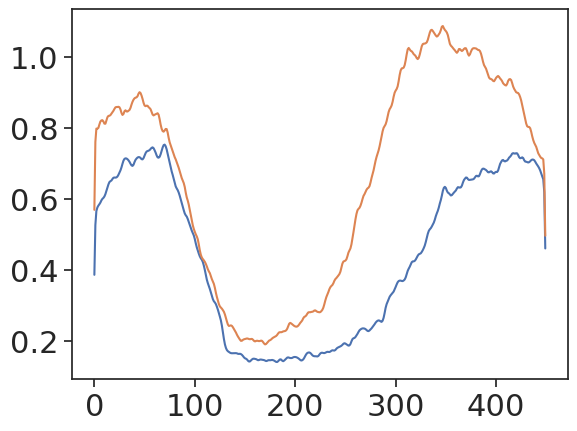

In [6]:
plt.plot(ave_act_low.mean(axis=0))
plt.plot(ave_act_high.mean(axis=0))